In [1]:
import pandas as pd
import numpy as np
#dataset loading
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [2]:
df.isnull().sum() #fihuring out missing values

,0
step,0
type,0
amount,0
nameOrig,1
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


In [3]:
df['type'].value_counts()

,count
type,
PAYMENT,70958
CASH_OUT,63918
CASH_IN,39913
TRANSFER,16165
DEBIT,1639


In [4]:
df['isFraud'].value_counts(normalize=True) #classwise proportion of fraud or not fraud(class imbalance check)

,proportion
isFraud,
0.0,0.999257
1.0,0.000743


In [5]:
df.dropna(inplace=True)

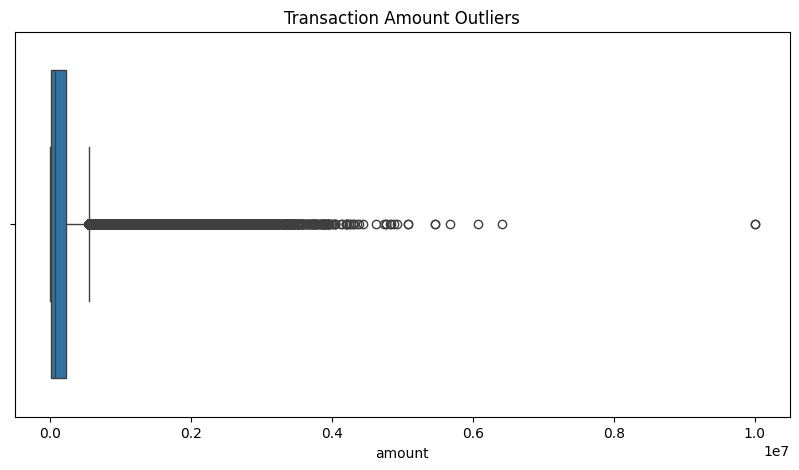

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot to visualize outliers
plt.figure(figsize=(10,5))
sns.boxplot(x=df['amount'])
plt.title("Transaction Amount Outliers")
plt.show()


In [6]:
df['errorBalOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [23]:

df['isHighAmount'] = (df['amount'] > 200000).astype(int)


In [7]:
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

In [9]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [10]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [24]:
print("Final columns:", df.columns.tolist())
print("Shape after cleaning:", df.shape)

Final columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'errorBalOrig', 'errorBalDest', 'isMerchant', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'isHighAmount']
Shape after cleaning: (192592, 16)


In [25]:
from sklearn.model_selection import train_test_split


X = df.drop('isFraud', axis=1)
y = df['isFraud']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Fraud ratio in train:", y_train.value_counts(normalize=True))
print("Fraud ratio in test:", y_test.value_counts(normalize=True))


Train shape: (154073, 15)
Test shape: (38519, 15)
Fraud ratio in train: isFraud
0.0    0.99926
1.0    0.00074
Name: proportion, dtype: float64
Fraud ratio in test: isFraud
0.0    0.999247
1.0    0.000753
Name: proportion, dtype: float64


In [26]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)


X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


print("Resampled training shape:", X_train_res.shape)
print("Class distribution after SMOTE:")
print(y_train_res.value_counts(normalize=True))


Resampled training shape: (307918, 15)
Class distribution after SMOTE:
isFraud
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


model = XGBClassifier(

    eval_metric='logloss',
    random_state=42
)

# model Training
model.fit(X_train_res, y_train_res)

# Prediction made ont test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [28]:

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

roc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC Score: {roc:.4f}")


Confusion Matrix:
[[38481     9]
 [    3    26]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9999    0.9998    0.9998     38490
         1.0     0.7429    0.8966    0.8125        29

    accuracy                         0.9997     38519
   macro avg     0.8714    0.9482    0.9062     38519
weighted avg     0.9997    0.9997    0.9997     38519


ROC-AUC Score: 0.9551


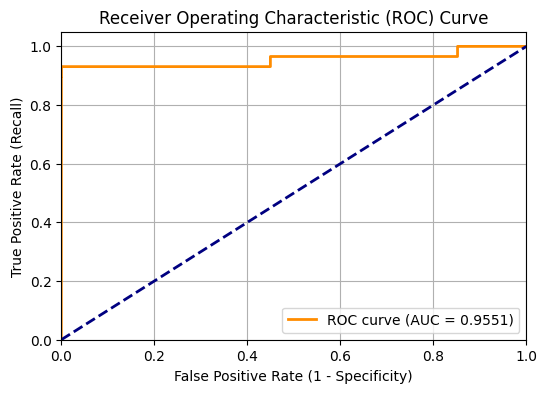

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


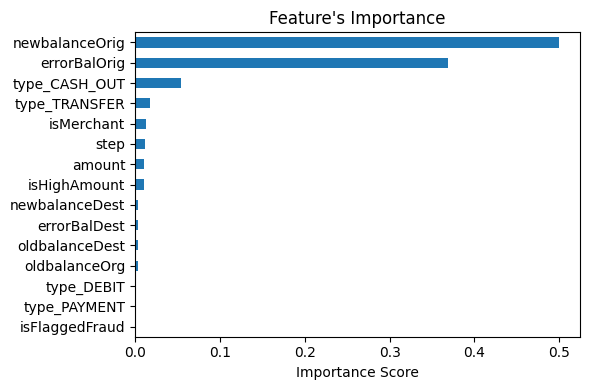

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

feature_imp = pd.Series(model.feature_importances_, index=X.columns)
feature_imp = feature_imp.sort_values(ascending=True)

plt.figure(figsize=(6,4))
feature_imp.plot(kind='barh')
plt.title("Feature's Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [30]:
# Converting boolean columns to int type to make it work with SHAP for extracting feature importance as it only takes int or float type as input
X_test_clean = X_test.copy()
for col in X_test_clean.select_dtypes(include='bool').columns:
    X_test_clean[col] = X_test_clean[col].astype(int)

print(X_test_clean.dtypes)


step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFlaggedFraud    float64
errorBalOrig      float64
errorBalDest      float64
isMerchant          int64
type_CASH_OUT       int64
type_DEBIT          int64
type_PAYMENT        int64
type_TRANSFER       int64
isHighAmount        int64
dtype: object


100%|===================| 38394/38519 [02:32<00:00]       

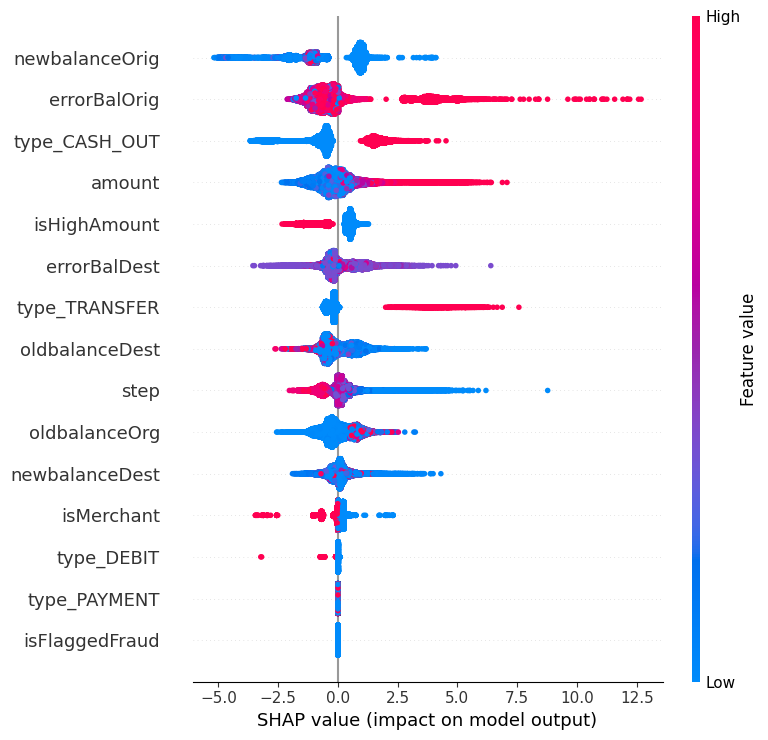

In [31]:
import shap

explainer = shap.Explainer(model, X_test_clean)
shap_values = explainer(X_test_clean)

# Created the summary plot for the features depicting their importance throughout
shap.summary_plot(shap_values, X_test_clean)


In [32]:
from sklearn.metrics import cohen_kappa_score
#calculated kappa coeff for assuring the model's prediction is absolute and not by chance
kap = cohen_kappa_score(y_test, y_pred)
print("Cohen’s Kappa Score:", kap)


Cohen’s Kappa Score: 0.8123454745195856
